### Phase analysis

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pycircular
import seaborn as sns
import xarray as xr
from frites.conn import conn_reshape_undirected
from scipy.stats import circmean, circstd, circvar
from tqdm import tqdm
from scipy.signal import find_peaks


from src.util import _extract_roi

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [4]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

#### Load data

In [5]:
DATA_PATH = os.path.expanduser("~/funcog/phaseanalysis/Results/lucy/141017")

#  average_power = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))
average_power = xr.load_dataarray(
    os.path.join(DATA_PATH, "average_power_whole_trial.nc")
)
power_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "power_time_series_surr_False.nc")
)
phase_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "phase_time_series_surr_False.nc")
)
phi_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "phase_difference_time_series_surr_False.nc")
)

#### Screening for peaks

In [6]:
bands = {
    "alpha": [6, 14]
}

In [7]:
average_power_norm = average_power / average_power.max("freqs")

In [8]:
peak_freqs, peak_prominences, rois = detect_peak_frequencies(average_power_norm, prominence=0)

[None, None]

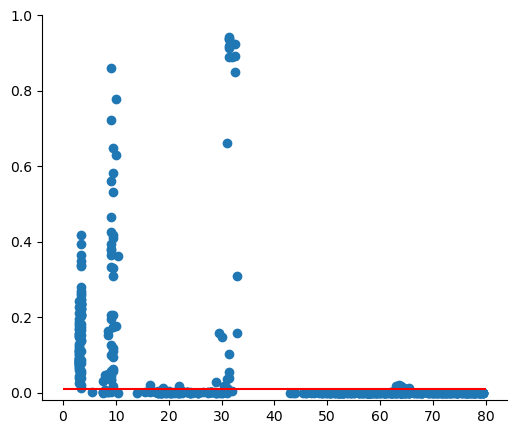

In [9]:
plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
plt.scatter(np.hstack(peak_freqs), np.hstack(peak_prominences))
plt.hlines(0.01, 0, 80, "r")
plt.ylim(-0.02, 1)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [10]:
peak_freqs, peak_prominences, rois = detect_peak_frequencies(average_power_norm, prominence=0.01)

In [11]:
has_peak = np.zeros((average_power_norm.sizes["roi"], len(bands)), dtype=bool)

for i in tqdm(range(average_power_norm.sizes["roi"])):
    for peak in peak_freqs[i]:
        for n_band, band in enumerate(bands.keys()):
            if not has_peak[i, n_band]:
                has_peak[i, n_band] = bands[band][0] <= peak <= bands[band][1]

has_peak = xr.DataArray(
    has_peak, dims=("roi", "bands"), coords=(average_power_norm.roi, list(bands.keys()))
)

peak_freqs = xr.DataArray(
    np.hstack(peak_freqs), dims="roi", coords={"roi": np.hstack(rois)}, name="peak_freq"
)

peak_prominences = xr.DataArray(
    np.hstack(peak_prominences),
    dims="roi",
    coords={"roi": np.hstack(rois)},
    name="peak_prom",
)

100%|████████████████████████████████████████████████████| 82/82 [00:00<00:00, 308183.63it/s]


In [12]:
rois = phi_series.roi.values
rois_s, rois_t = _extract_roi(rois, "-")

has_peaks_pairs = []

for roi_s, roi_t in zip(rois_s, rois_t):

    has_peaks_pairs += [ has_peak.sel(roi=[roi_s, roi_t]).all().data ]

In [13]:
has_peaks_pairs = xr.DataArray(has_peaks_pairs, dims=("roi"), coords={"roi": rois})

In [14]:
average_power  = average_power.isel(roi=has_peak.isel(bands=0).values)
power_time_series = power_time_series.isel(roi=has_peak.isel(bands=0).values)
phase_time_series = phase_time_series.isel(roi=has_peak.isel(bands=0).values)
phi_series = phi_series.isel(roi=has_peaks_pairs.values)

#### Compute power envelope correlations

In [15]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def _pec(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_pec(w_x, w_y):
        # computes the correlation
        return w[:, w_x, :, :] * w[:, w_y, :, :]

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_pec, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def _cok(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_pec(w_x, w_y):
        # computes the correlation
        x, y = w[:, w_x, :, :], w[:, w_y, :, :]
        k_xyxy = (
            (x * y * x * y).mean(-1)
            - 2 * (x * y).mean(-1) * (x * y).mean(-1)
            - (x * x).mean(-1) * (y * y).mean(-1)
        )
        return k_xyxy / ((np.abs(x) ** 2).mean(-1) * (np.abs(y) ** 2).mean(-1))

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_pec, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_envelope_correlations(power, n_jobs=1, verbose=False):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nepochs, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    # z-score data and parse to numpy
    z_power = (
        (power - power.mean(("epochs", "times"))) / power.std(("epochs", "times"))
    ).data

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _pec(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # cok = _cok(z_power, x_s, x_t, kw_para)
    # cok = np.stack(cok, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )
    """
    # conversion
    cok = xr.DataArray(
        cok,
        dims=dims[:-1],
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )
    """
    return pec  # , cok

In [16]:
pec = power_envelope_correlations(power_time_series)

Defining links (n_roi=43; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/903 [00:00<?,       ?it/s]

In [17]:
pec_cc = pec.mean("times")

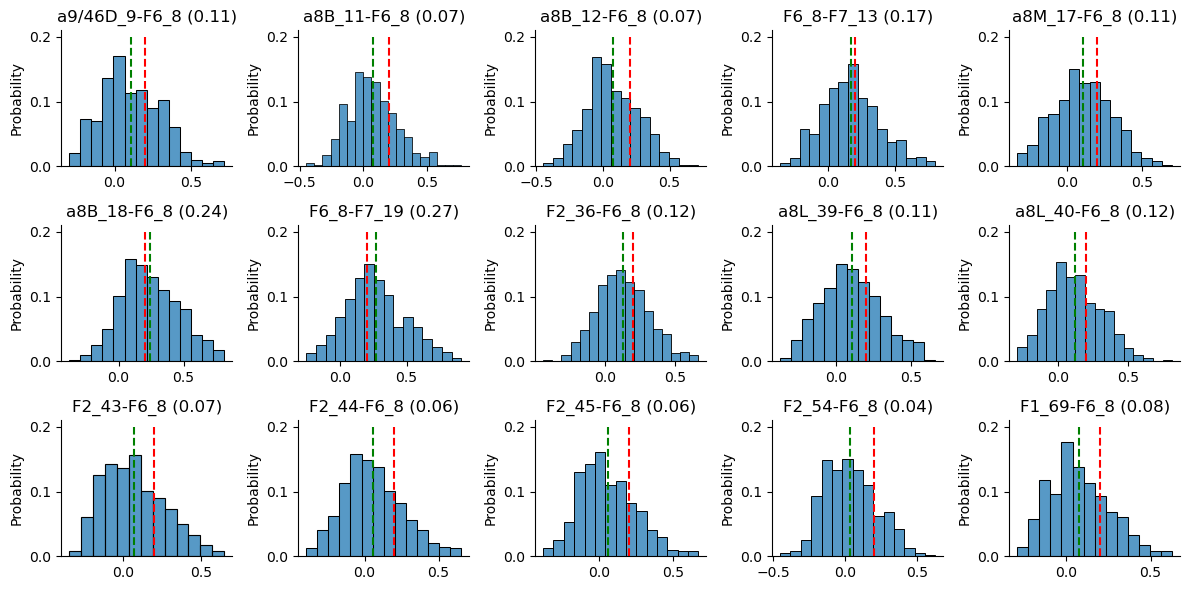

In [18]:
plt.figure(figsize=(12, 6))

roi_p = pec.roi.values

for pos, roi in enumerate(roi_p[:15]):

    ax = plt.subplot(3, 5, pos + 1)

    sns.histplot(
        pec_cc.sel(roi=roi).mean("epochs").isel(freqs=1),
        stat="probability",
        ax=ax,
    )

    mu = pec_cc.sel(roi=roi).mean("epochs").isel(freqs=1).mean()

    plt.vlines(0.2, 0, 0.2, "r", "--")

    plt.vlines(mu, 0, 0.2, "g", "--")

    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

    plt.title(f"{roi} ({mu.values:.2f})")

plt.tight_layout()

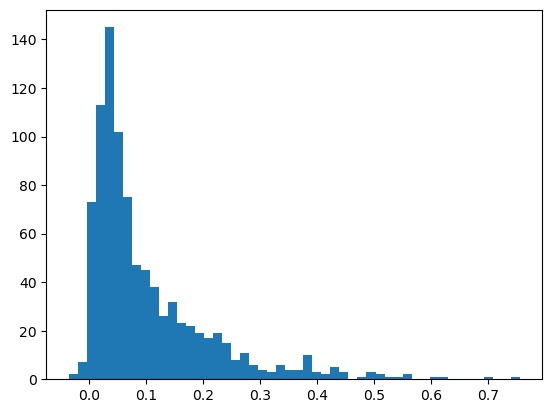

In [19]:
plt.hist(pec_cc.mean("epochs").mean("trials")[:, 1], 50);

#### Compute phase relations

In [20]:
from xarray_einstats.stats import circmean, circstd

In [21]:
crackles = pec >= pec.median(("times", "epochs"))

In [22]:
filtered_phi_series = xr.DataArray(
    np.where(~crackles, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [23]:
edges = phi_series.roi.data

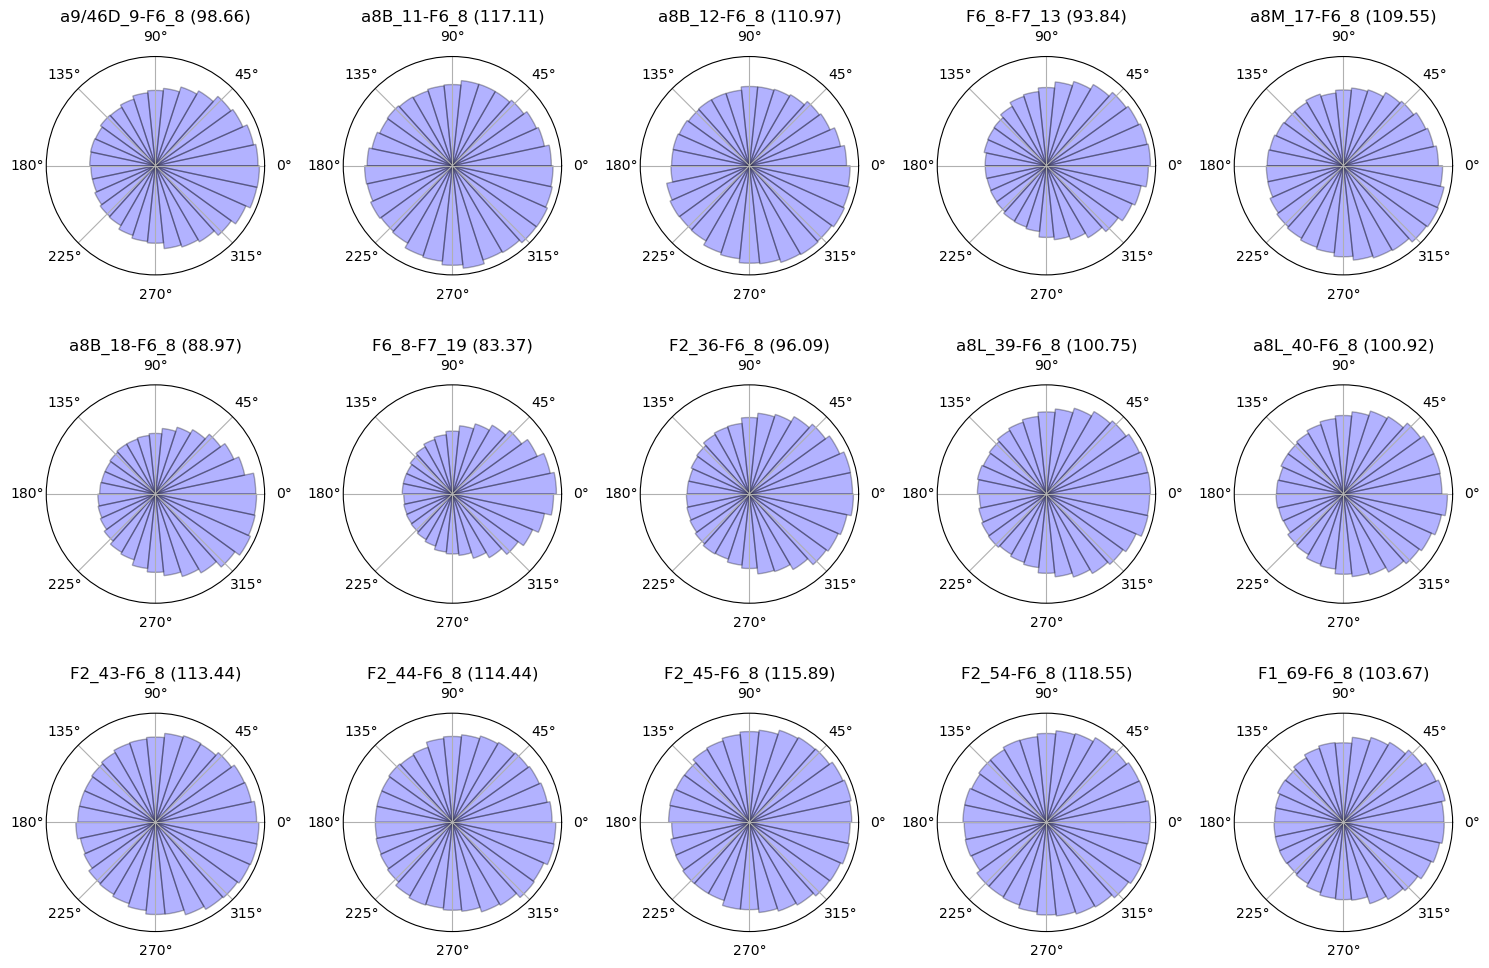

In [24]:
plt.figure(figsize=(15, 10))

for pos in range(15):  # range(phi_series.sizes["roi"]):

    ax = plt.subplot(3, 5, pos + 1, projection="polar")

    out = filtered_phi_series.sel(freqs=10, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)
    # mean = mean * 180 / np.pi
    # std = std * 180 / np.pi
    plt.title(f"{edges[pos]} ({(m_2 * 180 / np.pi):.2f})")

plt.tight_layout()

In [25]:
mu = circmean(filtered_phi_series, dims=("times", "epochs"), nan_policy="omit")
std = circstd(filtered_phi_series, dims=("times", "epochs"), nan_policy="omit")

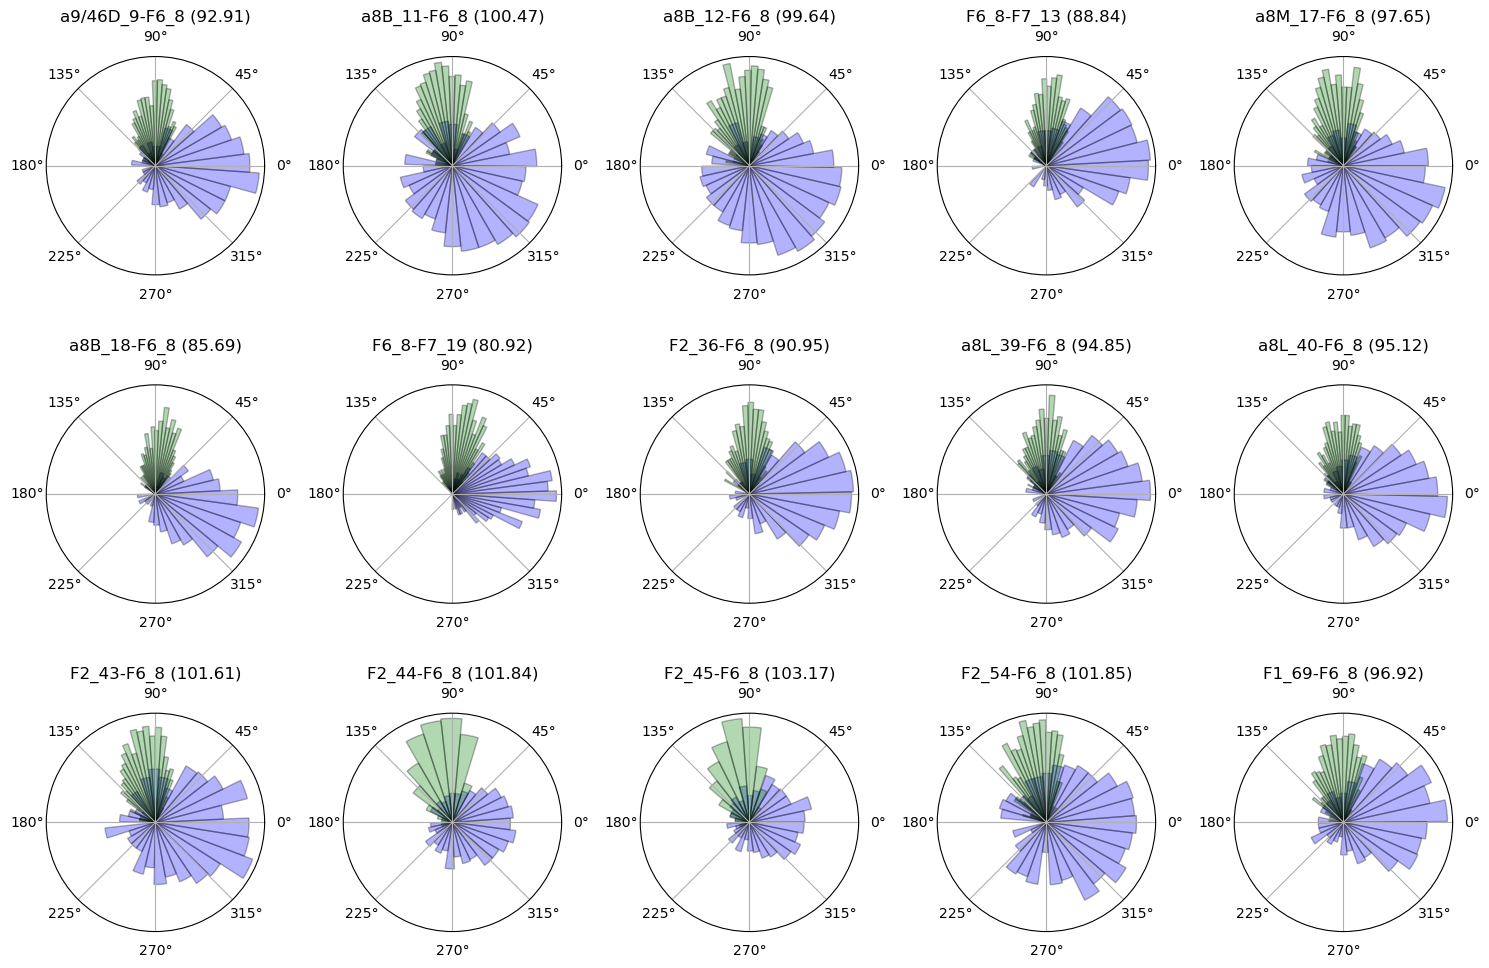

In [26]:
plt.figure(figsize=(15, 10))

for pos in range(15):  # range(phi_series.sizes["roi"]):

    ax = plt.subplot(3, 5, pos + 1, projection="polar")

    _mu = mu.sel(freqs=10, roi=edges[pos]).data.flatten()
    _std = std.sel(freqs=10, roi=edges[pos]).data.flatten()
    # out = out[~np.isnan(out)]https://open.spotify.com/track/1Hs0FkY3V7iwOZZVg6XIv1

    circular_hist(
        ax,
        _mu,
        bins=30,
        fill=True,
    )

    circular_hist(ax, _std, bins=30, fill=True, color="g")

    m_1, m_2 = pycircular.stats.periodic_mean_std(_std.data)
    # mean = mean * 180 / np.pi
    # std = std * 180 / np.pi
    plt.title(f"{edges[pos]} ({(m_1* 180 / np.pi):.2f})")

plt.tight_layout()

In [50]:
std_ = circmean(std, "trials")

In [51]:

average_power_epochs = average_power / average_power.max("freqs")
freqs = average_power_epochs.freqs.data
rois_s, rois_t = _extract_roi(pec_cc.roi.values, "-")

has_peaks = []
# 6 - 14
for roi_s, roi_t in zip(rois_s, rois_t):

    peak_s, _ = find_peaks(average_power_epochs.sel(roi=roi_s), prominence=0.01)
    peak_t, _ = find_peaks(average_power_epochs.sel(roi=roi_t), prominence=0.01)

    freqs_peak_s = freqs[peak_s]
    freqs_peak_t = freqs[peak_t]

    has_peak_s = False
    has_peak_t = False

    for peak_freq in freqs_peak_s:
        if peak_freq >= 6 and peak_freq <= 12:
            has_peak_s = True

    for peak_freq in freqs_peak_t:
        if peak_freq >= 6 and peak_freq <= 12:
            has_peak_t = True

    if has_peak_s and has_peak_t:
        has_peaks += [f"{roi_s}-{roi_t}"]

has_peaks = np.stack(has_peaks)

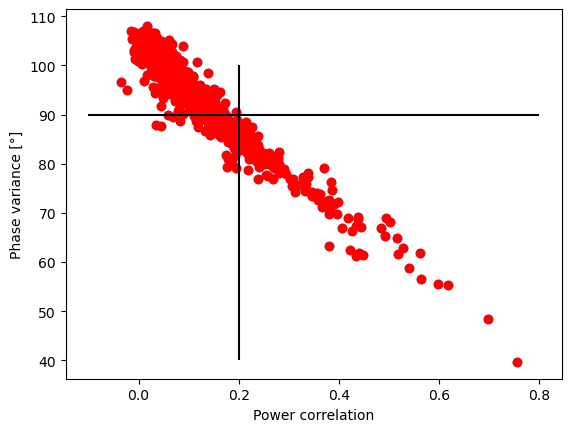

In [52]:
plt.scatter(pec_cc.mean(("epochs", "trials"))[:, 1], std_[:, 1] * 180 / np.pi)
plt.scatter(
    pec_cc.mean(("epochs", "trials"))[:, 1].sel(roi=has_peaks),
    std_[:, 1].sel(roi=has_peaks) * 180 / np.pi,
    c="r",
)

plt.xlabel("Power correlation")
plt.ylabel("Phase variance [°]")

plt.hlines(90, -0.1, 0.8, "k")
plt.vlines(0.2, 40, 100, "k")

(array([  1,   0,   1,   0,   3,   1,   8,   5,   9,  12,  17,  27,  38,
         51,  59,  79, 104, 156, 253,  79]),
 array([0.6925358 , 0.75217956, 0.81182333, 0.87146709, 0.93111086,
        0.99075462, 1.05039838, 1.11004215, 1.16968591, 1.22932967,
        1.28897344, 1.3486172 , 1.40826097, 1.46790473, 1.52754849,
        1.58719226, 1.64683602, 1.70647979, 1.76612355, 1.82576731,
        1.88541108]),
 <BarContainer object of 20 artists>)

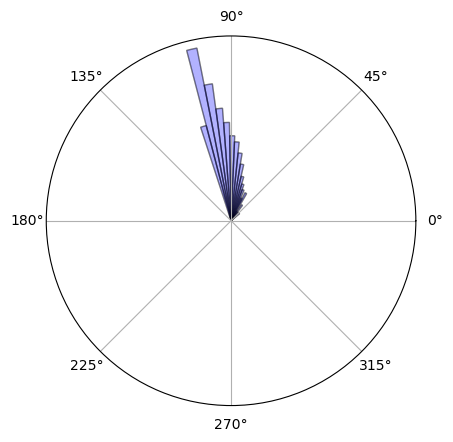

In [53]:
ax = plt.subplot(111, projection="polar")

circular_hist(
    ax,
    std_[:, 1],
    bins=20,
    fill=False,
)

circular_hist(
    ax,
    std_[:, 1].sel(roi=has_peaks),
    bins=20,
    fill=True,
)

In [54]:
avg_circ_mean = circmean(std, "trials") * 180 / np.pi <= 90

In [98]:
avg_pec = pec_cc.mean("epochs").mean("trials") >= 0.3

In [99]:
# plt.figure(figsize=(15, 6))
# plt.subplot(1, 2, 1)
# (pec_cc.mean("epochs").mean("trials") > 0.1).plot.imshow(cmap="binary")
# plt.subplot(1, 2, 2)
# out.plot.imshow(cmap="binary")

In [100]:
mask = avg_pec#np.logical_and(avg_pec, avg_circ_mean)

In [101]:
A = circmean(mu, "trials")

A = xr.DataArray(np.where(~mask, np.nan, A), dims=A.dims, coords=A.coords)

A = (A + np.pi) % (2 * np.pi) - np.pi

In [102]:
A_w = conn_reshape_undirected(A[..., 1], fill_value=np.nan)

/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


In [103]:
A_b = conn_reshape_undirected(mask[..., 1], fill_value=np.nan)

/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


In [104]:
from frites.plot import plot_conn_circle, plot_conn_heatmap

In [105]:
def WrapToPi(x):
    xwrap = x % 2 * np.pi
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap

<PolarAxes: >

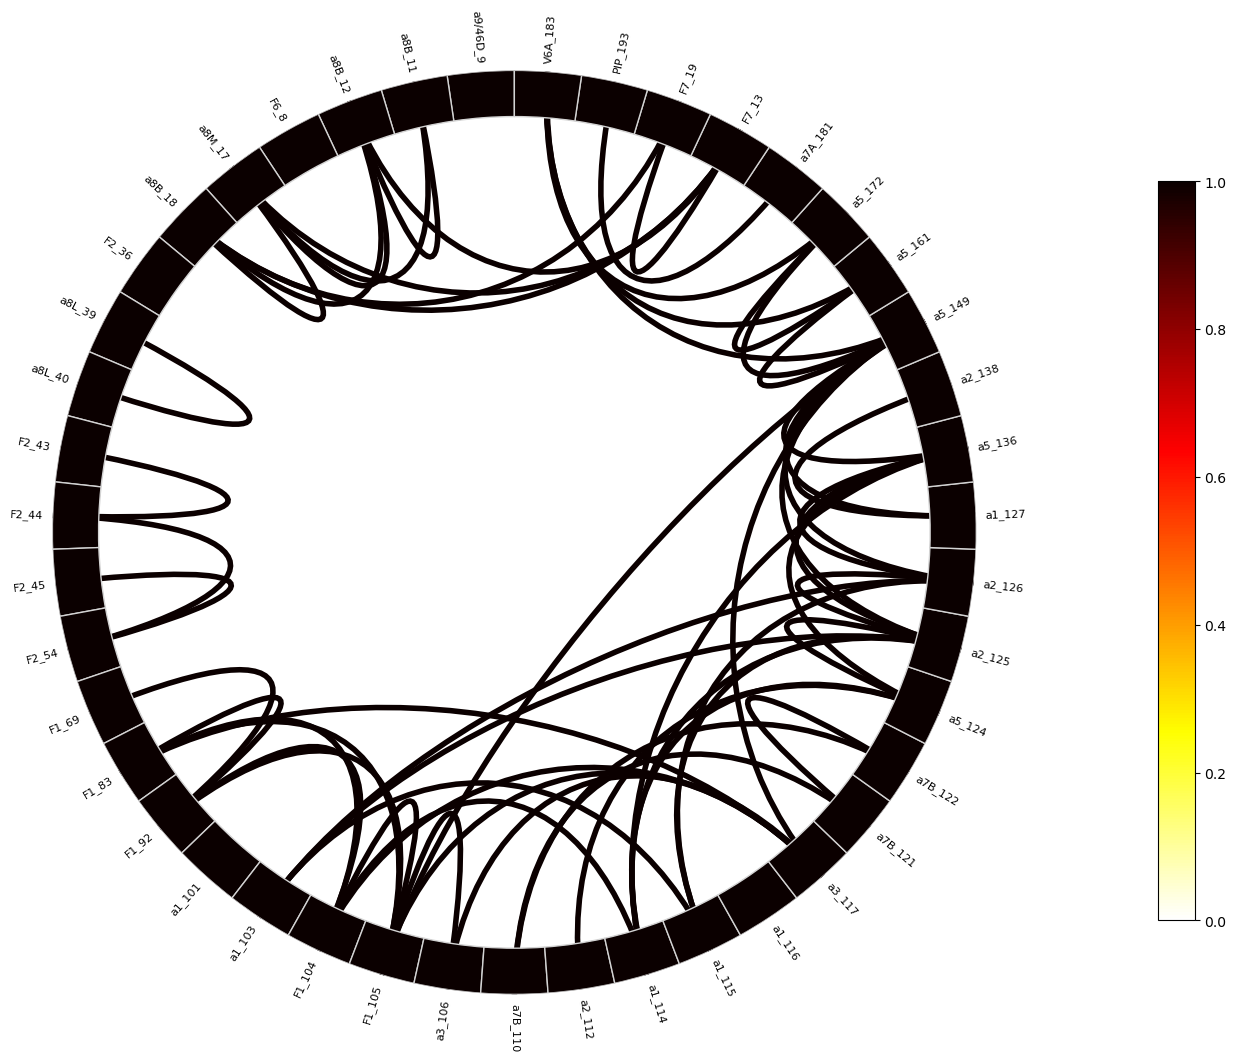

In [106]:
plot_conn_circle(A_b, edges_lw=4)

<PolarAxes: >

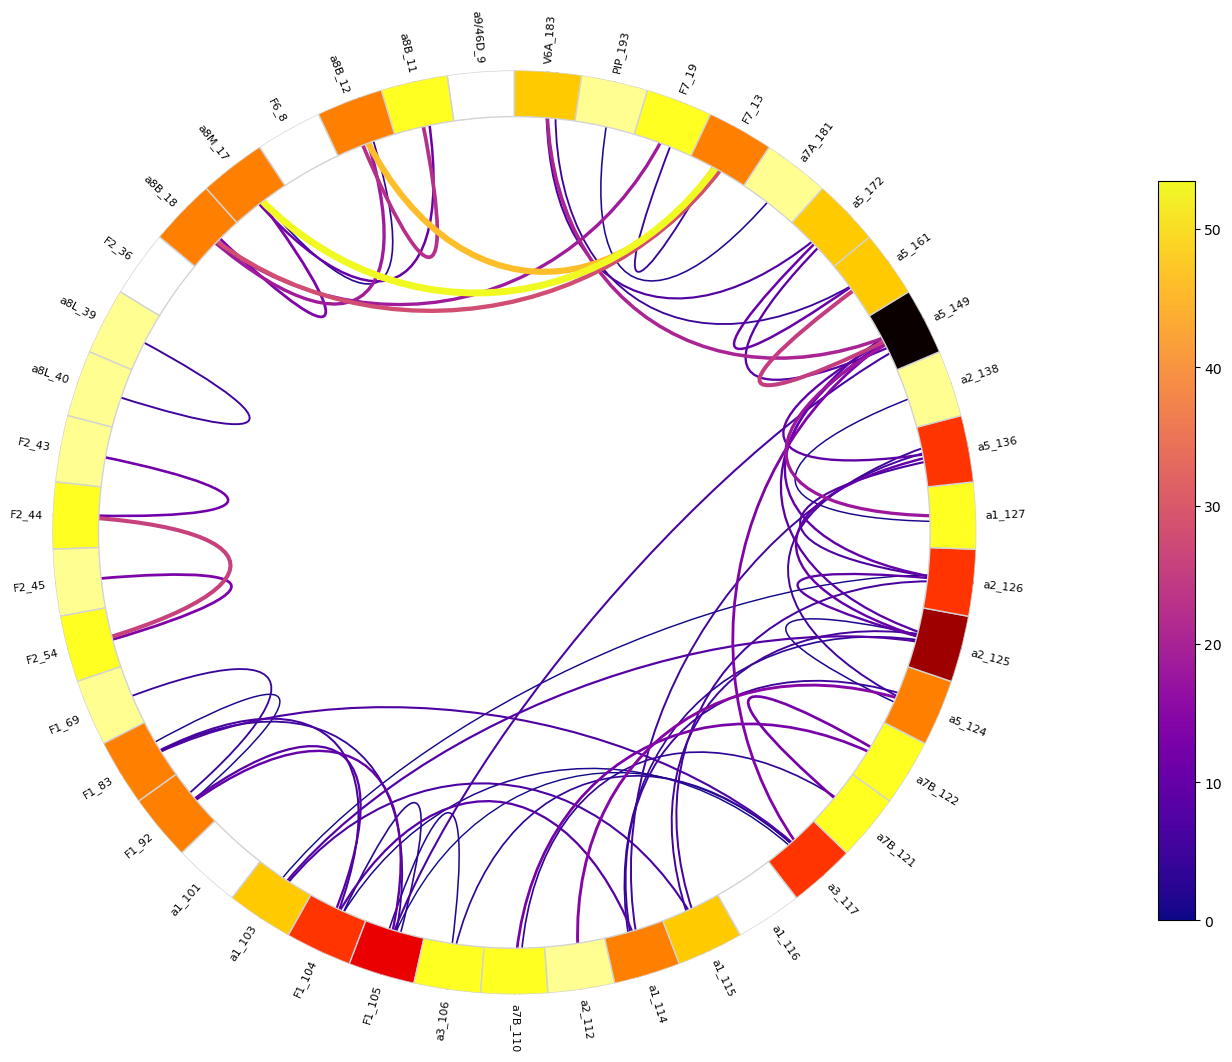

In [107]:
plot_conn_circle(
    np.abs(A_w) * 180 / np.pi,
    edges_cmap="plasma",
    edges_vmin=0,
    edges_vmax=None,
    edges_lw=5,
)

In [108]:
A_w_g = np.abs(A_w) * 180 / np.pi

In [109]:
_, _roi = _extract_roi(A_w_g.sources.data, "_")

In [110]:
A_w_g = (
    A_w_g.assign_coords({"sources": _roi, "targets": _roi})
    .groupby("sources")
    .mean("sources")
    .groupby("targets")
    .mean("targets")
)

<PolarAxes: >

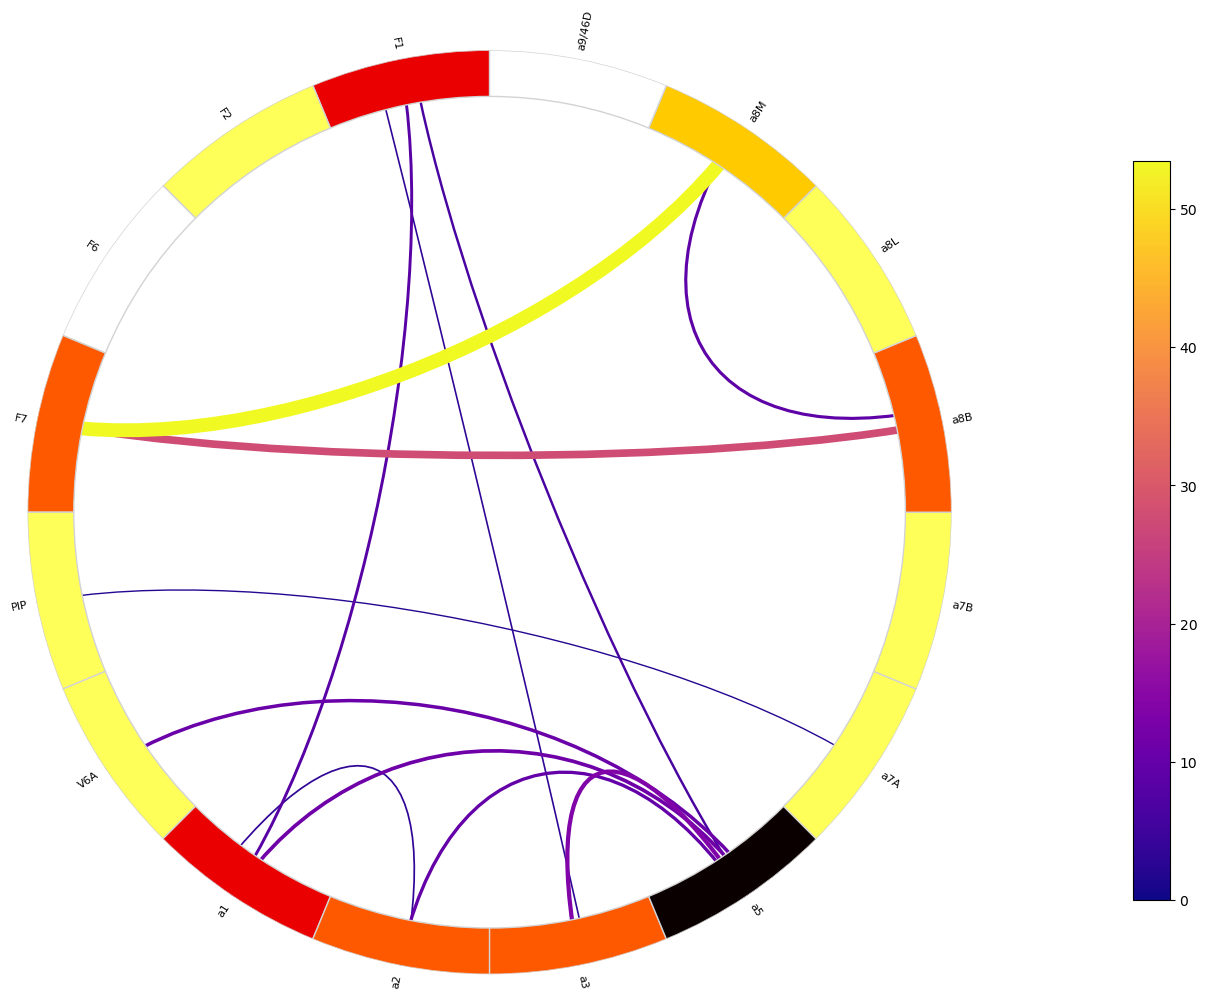

In [111]:
plot_conn_circle(A_w_g, edges_cmap="plasma", edges_vmin=0, edges_vmax=None, edges_lw=10)

In [69]:
roi_s, roi_t = _extract_roi(mask.roi.data, "-")

In [70]:
_, roi_s_n = _extract_roi(roi_s, "_")
_, roi_t_n = _extract_roi(roi_t, "_")

In [71]:
mask_auto = mask * (roi_s_n != roi_t_n)[:, None]

In [72]:
mask_auto

<xarray.DataArray 'pec' (roi: 903, freqs: 2)> Size: 2kB
array([[ True, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [ True,  True],
       [False, False]])
Coordinates:
  * roi      (roi) <U16 58kB 'a9/46D_9-F6_8' 'a8B_11-F6_8' ... 'PIP_193-V6A_183'
  * freqs    (freqs) int64 16B 5 10

In [73]:
A2 = xr.DataArray(np.where(~mask_auto, np.nan, A), dims=A.dims, coords=A.coords)

A2 = (A2 + np.pi) % (2 * np.pi) - np.pi

In [74]:
A_w2 = conn_reshape_undirected(A2[..., 1], fill_value=np.nan)
A_b2 = conn_reshape_undirected(mask_auto[..., 1], fill_value=np.nan)

/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(
/home/vinicius/Documents/frites/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index leve

<PolarAxes: >

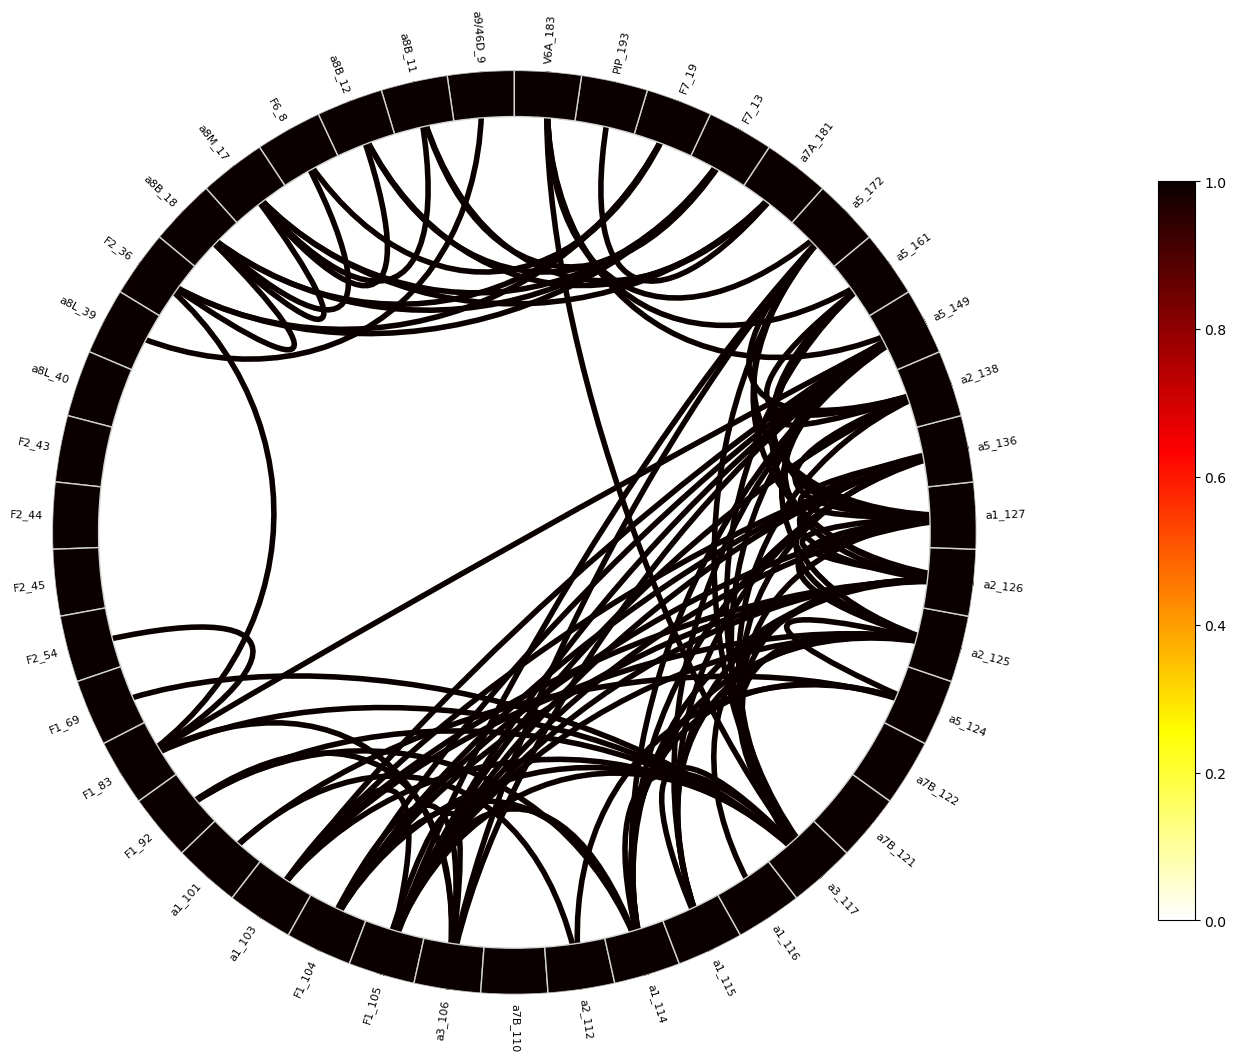

In [75]:
plot_conn_circle(A_b2, edges_lw=4)